# Create subgrid-scale models for various reactions

## Dependencies

Notebooks (links work only if the Docker container is running)

- [reduce_training_data.ipynb](http://127.0.0.1:8888/notebooks/reduce_training_data.ipynb)

## Load reduced training data

In [1]:
import helper_module as hm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib import rc
from matplotlib import ticker
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%matplotlib inline

data_path = "../data/sgs_data/"
output_path = "../output/"
output_path_model = output_path + "models/"

In [2]:
reactions = ["phys", "decay", "single", "cons"]
data_files = {}
for r in reactions:
    path = data_path + "{:s}_red.csv".format(r)
    data_files[r] = pd.read_csv(path, header=0)

## Feature distribution

In [3]:
def compute_2D_kernel_density(X, bandwidth, nx, ny):
    scaler = MinMaxScaler()
    X01 = scaler.fit_transform(X)
    xx, yy = np.mgrid[0.0:1.0:nx, 0.0:1.0:ny]
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T    
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X01)
    z = np.exp(kde.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

def savefig(name):
    plt.savefig(output_path + name + ".png", bbox_inches="tight")
    plt.savefig(output_path + name + ".pdf", bbox_inches="tight")

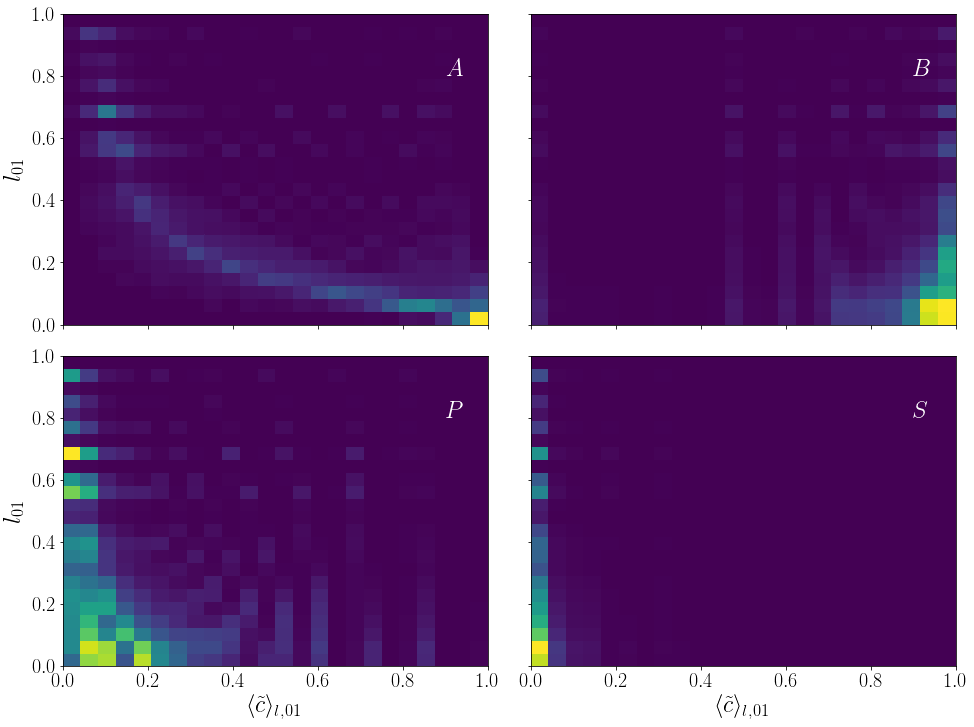

In [4]:
rc('text', usetex=True)
fig, axarr = plt.subplots(2, 2, figsize=(hm.figure_width, 12), sharex=True, sharey=True)

ind = [(i, j) for i in range(2) for j in range(2)]
select = [["dist", "A_av"], ["dist", "B_av"], ["dist", "P_av"], ["dist", "S_av"]]
data = data_files["cons"]
text = ["A", "B", "P", "S"]

for i, r in enumerate(select):
    row, col = ind[i]
    xx, yy, den = compute_2D_kernel_density(data[select[i]], 0.01, 25j, 25j)
    axarr[row, col].pcolormesh(xx, yy, den, cmap="viridis")
    axarr[row, col].set_xlim(0.0, 1.0)
    axarr[row, col].set_ylim(0.0, 1.0)
    axarr[row, col].tick_params(labelsize=hm.fontsize_tick)
    axarr[row, col].text(0.9, 0.8, r"${:s}$".format(text[i]), color="w", fontsize=hm.fontsize_label)

axarr[-1, 0].set_xlabel(r"$\langle \tilde{c} \rangle_{l,01}$", fontsize=hm.fontsize_label)
axarr[-1, 1].set_xlabel(r"$\langle \tilde{c} \rangle_{l,01}$", fontsize=hm.fontsize_label)
axarr[0, 0].set_ylabel(r"$l_{01}$", fontsize=hm.fontsize_label)
axarr[1, 0].set_ylabel(r"$l_{01}$", fontsize=hm.fontsize_label)
plt.subplots_adjust(hspace=0.1, wspace=0.1)
savefig("feature_density_cons")

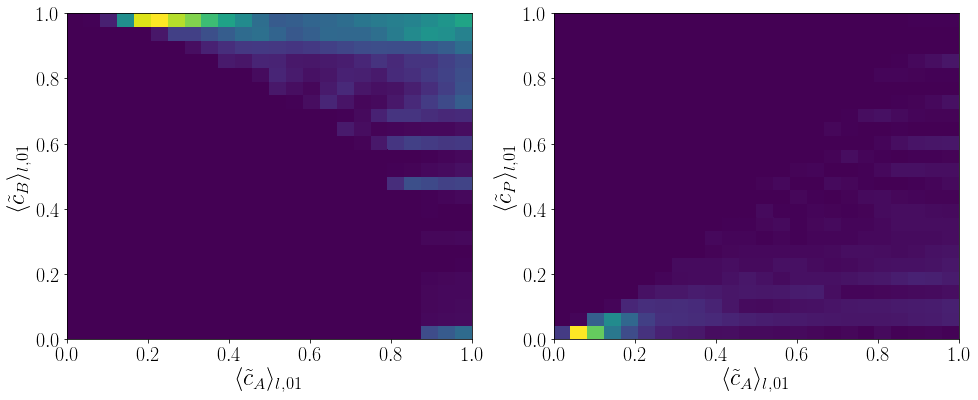

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(hm.figure_width, 6))

data = data_files["cons"]

xx, yy, den = compute_2D_kernel_density(data[["B_av", "A_av"]], 0.01, 25j, 25j)
ax1.pcolormesh(xx, yy, den, cmap="viridis")

xx, yy, den = compute_2D_kernel_density(data[["P_av", "A_av"]], 0.01, 25j, 25j)
ax2.pcolormesh(xx, yy, den, cmap="viridis")

for ax in [ax1, ax2]:
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.tick_params(labelsize=hm.fontsize_tick)
    ax.set_xlabel(r"$\langle \tilde{c}_A \rangle_{l,01}$", fontsize=hm.fontsize_label)

ax1.set_ylabel(r"$\langle \tilde{c}_B \rangle_{l,01}$", fontsize=hm.fontsize_label)
ax2.set_ylabel(r"$\langle \tilde{c}_P \rangle_{l,01}$", fontsize=hm.fontsize_label)

savefig("feature_density_source")

## Model training

In [6]:
# make torch results reproducible and use double precision
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(42)
np.random.seed(42)

def training_loop(model, path, x_train, y_train, y_weight, epochs, l_rate):
    """Optimize the weights of a given MLP.

    Parameters
    ----------
    model - SimpleMLP : model to optimize
    path - String : path to save best model weights
    x_train - array-like : feature vector of dimension [n_samples, n_features]
    y_train - array-like : label vector of dimension [n_samples, n_labels]
    y_weight - array-like : vector to put more weight on specific points in the training set; dimension [n_samples]
    epochs - Integer : number of epochs to train
    l_rate - Float : learning rate

    Returns
    -------
    history - List : loss developments over epochs
    model - SimpleMLP : opimized model in evaluation mode

    """
    if y_weight is None: y_weight = np.ones(x_train.shape[0])
    x_tensor = torch.from_numpy(x_train.astype(np.float64))
    y_tensor = torch.from_numpy(y_train.astype(np.float64))
    y_weight_tensor = torch.from_numpy(y_weight.astype(np.float64))
    zero = torch.zeros(y_tensor.shape[0])

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)

    best_loss = 1.0E5
    train_loss = []

    for e in tqdm(range(1, epochs+1)):
        optimizer.zero_grad()
        output = model.forward(x_tensor)
        diff = (output.squeeze(dim=1) - y_tensor) * y_weight_tensor
        loss = criterion(diff, zero)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), path)
    return model.eval(), np.asarray(train_loss)

model_dict = {
    "n_inputs" : 2,
    "n_outputs" : 1,
    "n_layers" : 6,
    "n_neurons" : 40,
    "activation" : torch.nn.functional.relu,
    "batch_norm" : False
}

### Physisorption

In [7]:
phys_labels = ["gradA_s", "gradA_f", "A_f"]
data = data_files["phys"]
scaler_A = MinMaxScaler()
X01_A = scaler_A.fit_transform(data[["dist", "A_av"]].values)

In [8]:
all_losses = []
epochs = 5000

for i, label in enumerate(phys_labels):
    y = data[label].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "phys_" + label + ".pt"
    model, losses = training_loop(model, model_path, X01_A, y01, None, epochs, 0.001)
    all_losses.append(losses)

100%|██████████| 5000/5000 [04:01<00:00, 20.71it/s]


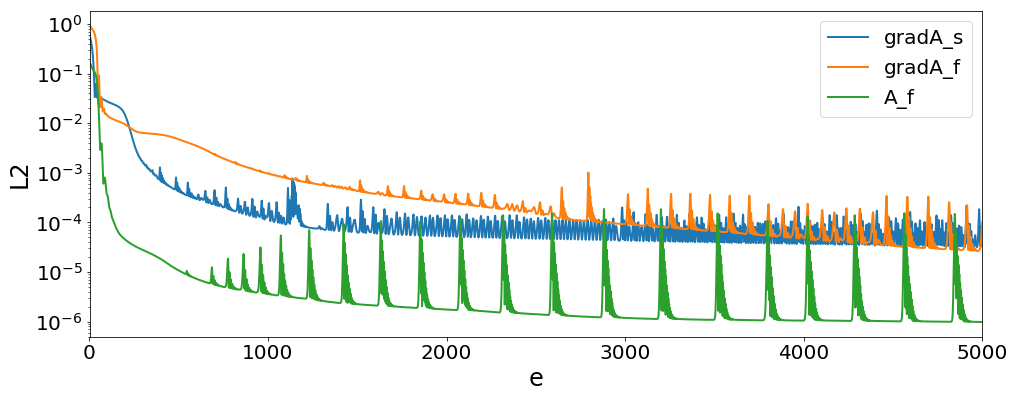

In [9]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

for i, loss in enumerate(all_losses):
    ax.plot(range(1, epochs+1), loss, ls="-", lw=2, label=phys_labels[i])
    
ax.set_xlabel("e", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("L2", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)

### Decay reaction

In [10]:
decay_labels_A = ["gradA_s", "gradA_f", "A_f"]
decay_labels_P = ["gradP_f", "P_f"]
data = data_files["decay"]
scaler_A = MinMaxScaler()
scaler_AP = MinMaxScaler()
X01_A = scaler_A.fit_transform(data[["dist", "A_av"]].values)
X01_AP = scaler_AP.fit_transform(data[["dist", "A_av", "P_av"]].values)

In [11]:
all_losses = []
epochs = 5000

for X_species, species_labels in zip([X01_A, X01_AP],[decay_labels_A, decay_labels_P]):
    for i, label in enumerate(species_labels):
        model_dict["n_inputs"] = X_species.shape[1]
        y = data[label].values
        y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
        model = hm.SimpleMLP(**model_dict)
        model_path = output_path_model + "decay_" + label + ".pt"
        model, losses = training_loop(model, model_path, X_species, y01, None, epochs, 0.001)
        all_losses.append(losses)

100%|██████████| 5000/5000 [10:34<00:00,  7.88it/s]


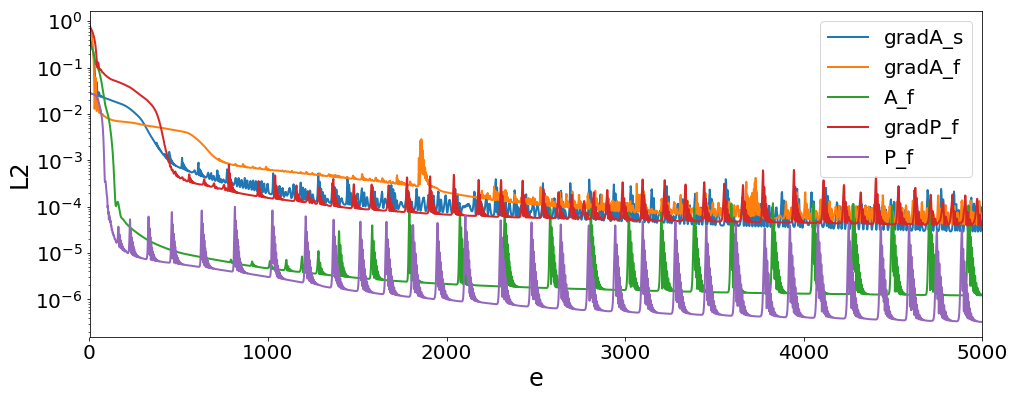

In [12]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

decay_labels = decay_labels_A + decay_labels_P
for i, loss in enumerate(all_losses):
    ax.plot(range(1, epochs+1), loss, ls="-", lw=2, label=decay_labels[i])
    
ax.set_xlabel("e", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("L2", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)

### Single reaction

In [13]:
single_labels_A = ["gradA_s", "gradA_f", "A_f"]
single_labels_B = ["gradB_f", "B_f"]
single_labels_P = ["gradP_f", "P_f"]
data = data_files["single"]
scaler_AB = MinMaxScaler()
scaler_ABP = MinMaxScaler()
X01_AB = scaler_AB.fit_transform(data[["dist", "A_av", "B_av"]].values)
X01_ABP = scaler_ABP.fit_transform(data[["dist", "A_av", "B_av", "P_av"]].values)

In [14]:
all_losses = []
epochs = 5000

for X_species, species_labels in zip([X01_AB, X01_AB, X01_ABP], [single_labels_A, single_labels_B, single_labels_P]):
    for i, label in enumerate(species_labels):
        model_dict["n_inputs"] = X_species.shape[1]
        y = data[label].values
        y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
        model = hm.SimpleMLP(**model_dict)
        model_path = output_path_model + "single_" + label + ".pt"
        model, losses = training_loop(model, model_path, X_species, y01, None, epochs, 0.001)
        all_losses.append(losses)

100%|██████████| 5000/5000 [06:25<00:00, 12.97it/s]


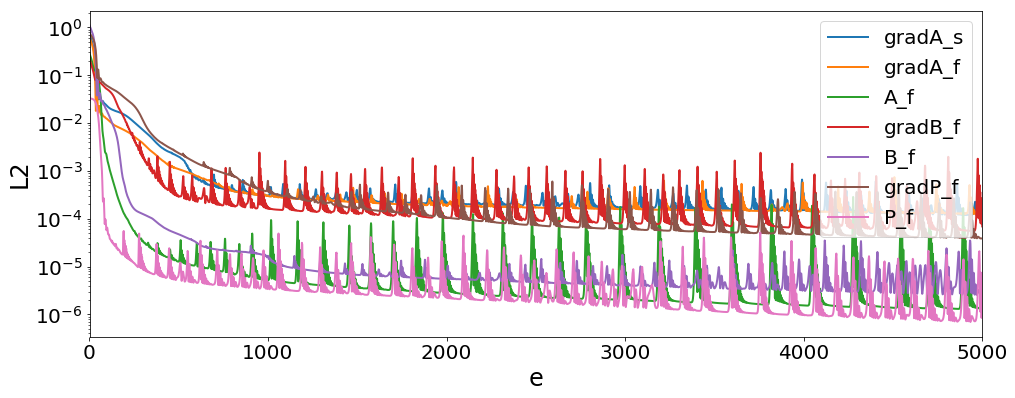

In [15]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

single_labels = single_labels_A + single_labels_B + single_labels_P
for i, loss in enumerate(all_losses):
    ax.plot(range(1, epochs+1), loss, ls="-", lw=2, label=single_labels[i])
    
ax.set_xlabel("e", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("L2", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)

### Consecutive reaction

In [16]:
cons_labels_A = ["gradA_s", "gradA_f", "A_f"]
cons_labels_B = ["gradB_f", "B_f"]
cons_labels_P = ["gradP_f", "P_f"]
cons_labels_S = ["gradS_f", "S_f"]
data = data_files["cons"]
scaler_ABP = MinMaxScaler()
scaler_ABPS = MinMaxScaler()
X01_ABP = scaler_ABP.fit_transform(data[["dist", "A_av", "B_av", "P_av"]].values)
X01_ABPS = scaler_ABPS.fit_transform(data[["dist", "A_av", "B_av", "P_av", "S_av"]].values)

In [17]:
all_losses = []
epochs = 5000

for X_species, species_labels in zip([X01_ABP, X01_ABP, X01_ABP, X01_ABPS], [cons_labels_A, cons_labels_B, cons_labels_P, cons_labels_S]):
    for i, label in enumerate(species_labels):
        model_dict["n_inputs"] = X_species.shape[1]
        y = data[label].values
        y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
        model = hm.SimpleMLP(**model_dict)
        model_path = output_path_model + "cons_" + label + ".pt"
        model, losses = training_loop(model, model_path, X_species, y01, None, epochs, 0.001)
        all_losses.append(losses)

100%|██████████| 5000/5000 [06:54<00:00, 12.06it/s]


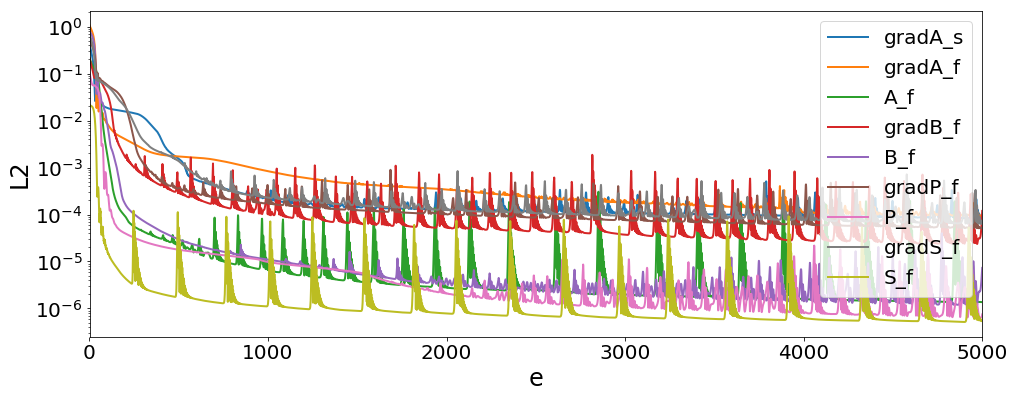

In [18]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

cons_labels = cons_labels_A + cons_labels_B + cons_labels_P + cons_labels_S
for i, loss in enumerate(all_losses):
    ax.plot(range(1, epochs+1), loss, ls="-", lw=2, label=cons_labels[i])
    
ax.set_xlabel("e", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("L2", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)

### Reaction source terms

In [19]:
rAB_label = "rAB_av"
data = data_files["single"]
scaler_AB = MinMaxScaler()
X01_AB = scaler_AB.fit_transform(data[["dist", "A_av", "B_av"]].values)

In [20]:
epochs = 5000

model_dict["n_inputs"] = X01_AB.shape[1]
y = data[rAB_label].values
y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
model = hm.SimpleMLP(**model_dict)
model_path = output_path_model + "single_" + rAB_label + ".pt"
model, losses = training_loop(model, model_path, X01_AB, y01, None, epochs, 0.001)

100%|██████████| 5000/5000 [06:45<00:00, 12.34it/s]


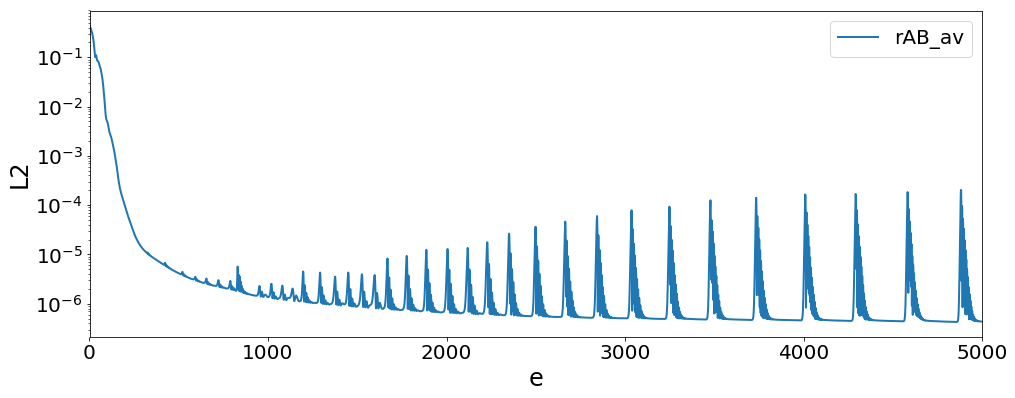

In [21]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

ax.plot(range(1, epochs+1), losses, ls="-", lw=2, label=rAB_label)
    
ax.set_xlabel("e", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("L2", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)

In [22]:
cons_r_labels = ["rAB_av", "rAP_av"]
data = data_files["cons"]
scaler_AB = MinMaxScaler()
scaler_AP = MinMaxScaler()
X01_AB = scaler_AB.fit_transform(data[["dist", "A_av", "B_av"]].values)
X01_AP = scaler_AP.fit_transform(data[["dist", "A_av", "P_av"]].values)

In [23]:
all_losses = []
epochs = 5000

for i, (X_r, label_r) in enumerate(zip([X01_AB, X01_AP], cons_r_labels)):
    model_dict["n_inputs"] = X_r.shape[1]
    y = data[label_r].values
    y01 = (y - np.min(y)) / (np.max(y) - np.min(y))
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path_model + "cons_" + label_r + ".pt"
    model, losses = training_loop(model, model_path, X_r, y01, None, epochs, 0.001)
    all_losses.append(losses)

100%|██████████| 5000/5000 [06:44<00:00, 12.36it/s]


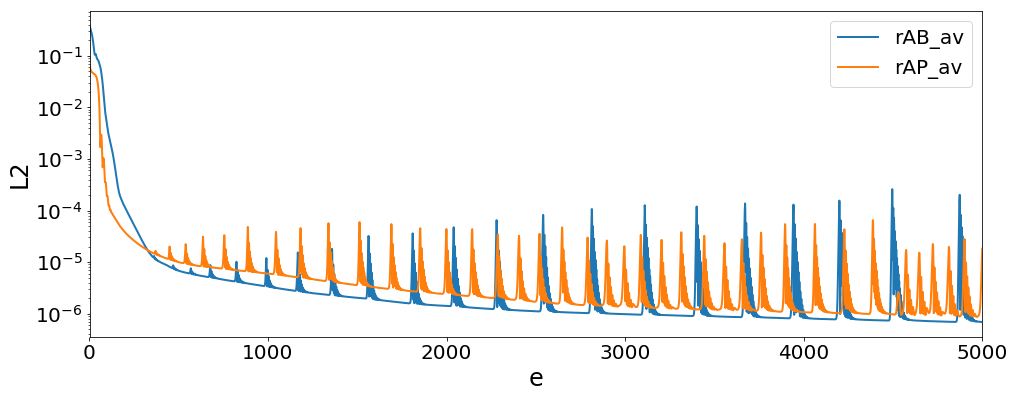

In [24]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

for i, loss in enumerate(all_losses):
    ax.plot(range(1, epochs+1), loss, ls="-", lw=2, label=cons_r_labels[i])
    
ax.set_xlabel("e", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("L2", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)